<a href="https://colab.research.google.com/github/navidakbari/ENEL645_Project/blob/main/ENEL645_Project/Final%20Phase%20Code/ENEL645_Final_Project_LSTM_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import numpy as np
import tensorflow as tf
import os
from os.path import isfile, join
import pandas as pd
import matplotlib.pylab as plt
from sklearn import preprocessing
import skimage
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
import random

In [26]:
#data_folder = '/content/drive/MyDrive/ENEL 645 (Final Project) (LSTM DBA)/UAH-DRIVESET-v1/'
data_folder = '/content/drive/MyDrive/Colab Notebooks/UAH-DRIVESET-v1'

In [27]:
def get_dataset(data_path, shape, train_per = 0.7, val_per = 0.1, test_per = 0.2, shuffel = False, delta = False, overlapping = True):
    # initialize data variable as list
    X_train, Y_train, X_val, Y_val, X_test, Y_test = [], [], [], [], [], []

    for root, dirs, files in os.walk(data_path, topdown=False):
      if len(files) < 2:
          continue
      else:
          gps_df = get_data_list(root, shape, delta, overlapping)
          if shuffel:
              random.shuffle(gps_df)
          
          train_split_index = int(train_per * len(gps_df))
          val_split_index = int(val_per * len(gps_df)) + train_split_index

          X_train.extend(gps_df[: train_split_index])
          for i in range(train_split_index):
            Y_train.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])

          X_val.extend(gps_df[train_split_index:val_split_index])
          for i in range(train_split_index, val_split_index):
            Y_val.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])

          X_test.extend(gps_df[val_split_index:])
          for i in range(val_split_index, len(gps_df)):
            Y_test.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])

    labels_columns = ["driver", "type", "road"]
    Y_train = pd.DataFrame(data= np.array(Y_train), columns=labels_columns)
    Y_val = pd.DataFrame(data= np.array(Y_val), columns=labels_columns)
    Y_test = pd.DataFrame(data= np.array(Y_test), columns=labels_columns)
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

def get_generalized_dataset(data_path, shape, train_per = 0.7, val_per = 0.1, test_per = 0.2):
    # initialize data variable as list
    X_train, Y_train, X_val, Y_val, X_test, Y_test = [], [], [], [], [], []

    for root, dirs, files in os.walk(data_path, topdown=False):
        if len(files) < 2:
            continue
        else:
            gps_df = get_data_list(root, shape,True,True)
            
            # train_split_index = int(train_per * len(gps_df))
            # val_split_index = int(val_per * len(gps_df)) + train_split_index
            if root.split("/")[-1].split("-")[2] in ['D1', 'D2', 'D3', 'D4']:
                X_train.extend(gps_df)
                for i in range(len(gps_df)):
                    Y_train.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])
            elif root.split("/")[-1].split("-")[2] == 'D5':
                X_val.extend(gps_df)
                for i in range(len(gps_df)):
                    Y_val.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])
            elif root.split("/")[-1].split("-")[2] == 'D6':
                X_test.extend(gps_df)
                for i in range(len(gps_df)):
                    Y_test.append([root.split("/")[-1].split("-")[2], get_trip_labels(root), get_road_type(root)])

    labels_columns = ["driver", "type", "road"]
    Y_train = pd.DataFrame(data= np.array(Y_train), columns=labels_columns)
    Y_val = pd.DataFrame(data= np.array(Y_val), columns=labels_columns)
    Y_test = pd.DataFrame(data= np.array(Y_test), columns=labels_columns)
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

def get_data_list(root, shape, delta, overlapping):
    data_list = []
    gps_df = import_uah_trip_data(root)
    if delta:
        gps_df["delta_latitude"] = gps_df.latitude.diff()
        gps_df["delta_longitude"] = gps_df.longitude.diff()
        gps_df["delta_altitude"] = gps_df.altitude.diff()
        gps_df["delta_latitude"][0] = 0
        gps_df["delta_longitude"][0] = 0
        gps_df["delta_altitude"][0] = 0 
        gps_df["road_type"] = get_road_type(root)
    if overlapping:
        lenght = int(len(gps_df)-shape)
        for i in range(lenght):
          data_list.append(gps_df[i:i+shape])
    else:
        divisions = int(len(gps_df)/shape)
        gps_df = gps_df[:divisions * shape]
        for i in range(divisions):
            data_list.append(gps_df[shape * (i):shape * (i+1)])
    return data_list

def import_uah_trip_data(root_path):
    # import raw inertial data
    gps_file_path = os.path.join(root_path, "RAW_GPS.txt")
    gps_df = pd.read_csv(gps_file_path, sep=" ", header=None).iloc[:, 0:7]
    # add the column names
    gps_df.columns = [
        "timestamp",
        "speed",
        "latitude",
        "longitude",
        "altitude",
        "verticalAccuracy",
        "horizentalAccuracy",
    ]
    dataFrame = pd.DataFrame(data=gps_df, columns=gps_df.columns)
    return dataFrame

def get_trip_labels(file_path):
    if "NORMAL" in file_path:
        label = "NORMAL"
    elif "AGGRESSIVE" in file_path:
        label = "AGGRESSIVE"
    elif "DROWSY" in file_path:
        label = "DROWSY"
    else:
        label = None
    return label

def get_road_type(file_path):
    if "SECONDARY" in file_path:
        return 1
    elif "MOTORWAY" in file_path:
        return 2
    else:
        return None

def f1(y_true, y_pred):
  def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

  def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

def normalization(X_train, X_val, X_test, type = 'standardization'):
    if type == 'min-max':
        for i in range(len(X_train[0,0])):
            train_min, train_max = X_train[:,0,i].min(),X_train[:,0,i].max() 
            X_train[:,0,i] = (X_train[:,0,i] - train_min)/(train_max - train_min)
            X_val[:,0,i] = (X_val[:,0,i] - train_min)/(train_max - train_min)
            X_test[:,0,i] = (X_test[:,0,i] - train_min)/(train_max - train_min)
    elif type == 'standardization':
        for i in range(len(X_train[0,0])):
            train_mean, train_std = X_train[:,0,i].mean(),X_train[:,0,i].std() 
            X_train[:,0,i] = (X_train[:,0,i] - train_mean)/train_std
            X_val[:,0,i] = (X_val[:,0,i] - train_mean)/train_std
            X_test[:,0,i] = (X_test[:,0,i] - train_mean)/train_std
    return X_train, X_val, X_test

def oneHotEndcoding(Y_train, Y_val, Y_test):
    Y_train_oh = pd.get_dummies(Y_train.type, prefix='type')
    Y_val_oh = pd.get_dummies(Y_val.type, prefix='type')
    Y_test_oh = pd.get_dummies(Y_test.type, prefix='type')
    return Y_train_oh, Y_val_oh, Y_test_oh

def dataset_preparation(data_folder = data_folder, shape=40, normalization_type = 'standardization',delta= False,shuffle=False\
                        ,get_generalized = False):
  if get_generalized:
    X_train, Y_train, X_val, Y_val, X_test, Y_test = get_generalized_dataset(data_folder,shape)
  X_train, Y_train, X_val, Y_val, X_test, Y_test = get_dataset(data_folder,shape,delta=delta,shuffel=shuffle)
  if normalization != None:
    X_train, X_val, X_test = normalization(X_train, X_val, X_test,type = normalization_type)
  Y_train_oh, Y_val_oh, Y_test_oh = oneHotEndcoding(Y_train, Y_val, Y_test)
  Y_train, Y_val, Y_test = np.array(Y_train), np.array(Y_val), np.array(Y_test)
  Y_train_oh, Y_val_oh, Y_test_oh = np.array(Y_train_oh),np.array(Y_val_oh),np.array(Y_test_oh)
  return X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh

def callbacks_function(name):
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights=True)
  monitor = tf.keras.callbacks.ModelCheckpoint(name, monitor='val_loss', verbose=0,save_best_only=True\
                                               ,save_weights_only=True,mode='min')
  
  def scheduler(epoch, lr):
    if epoch%5 == 0:
      lr = lr/2
    return lr

  lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)
  
  return early_stop, monitor, lr_schedule

def model_comiple_run(model,X_train,Y_train_oh,X_val,Y_val_oh,callbacks):
  model.compile(optimizer= 'adam', loss= 'CategoricalCrossentropy',metrics=['accuracy',f1])
  model_history = model.fit(X_train, Y_train_oh, epochs= 200, batch_size= 32,validation_data=(X_val,Y_val_oh)\
                            ,callbacks=callbacks,verbose=1)
  return model_history

#function definition for ploting the accuracy graph for train and validation sets.
def model_plot(model_history, type = None, plot_all = True):
  plt.plot()
  if plot_all:
    plt.plot(model_history.history['accuracy'], label = "Train accuracy")
    plt.plot(model_history.history['val_accuracy'], label = "Val accuracy")
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.show()
    plt.plot(model_history.history['loss'], label = "Train loss")
    plt.plot(model_history.history['val_loss'], label = "Val loss")
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Loss") 
    plt.grid()
    plt.legend()
    plt.show()
    plt.plot(model_history.history['f1'], label = "Train f1")
    plt.plot(model_history.history['val_f1'], label = "Val f1")
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("F1")
    plt.grid()
    plt.legend()
    plt.show()
  else:
    if type=='accuracy':
      plt.plot(model_history.history['accuracy'], label = "Train accuracy")
      plt.plot(model_history.history['val_accuracy'], label = "val_accuracy")
    if type=='loss':
      plt.plot(model_history.history['loss'], label = "Train loss")
      plt.plot(model_history.history['val_loss'], label = "val_loss")
    if type=='f1':
      plt.plot(model_history.history['f1'], label = "Train f1")
      plt.plot(model_history.history['val_f1'], label = "val_f1")
    plt.legend()
    plt.show()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 40)                7680      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 123       
Total params: 7,803
Trainable params: 7,803
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
660/660 [==============================] - 4s 5ms/step - loss: 1.0961 - accuracy: 0.4100 - f1: 0.0539 - val_loss: 1.0845 - val_accuracy: 0.3658 - val_f1: 0.0000e+00
Epoch 2/200
660/660 [==============================] - 3s 4ms/step - loss: 1.0286 - accuracy: 0.4834 - f1: 0.1007 - val_loss: 1.0276 - val_accuracy: 0.3695 - val_f1: 0.0864
Epoch 3/200
660/660 [==============================] - 3s 4ms/step - loss: 1.0017 - accuracy: 0.4900 - f1: 0.1809 - val_loss: 1.0525 - val_accuracy: 0.3591 - val_f

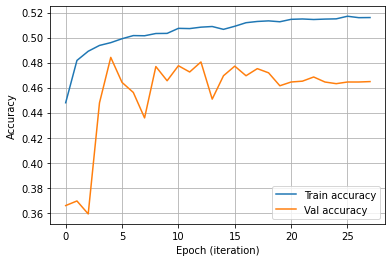

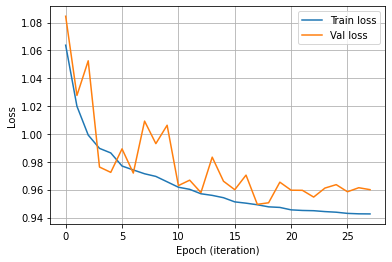

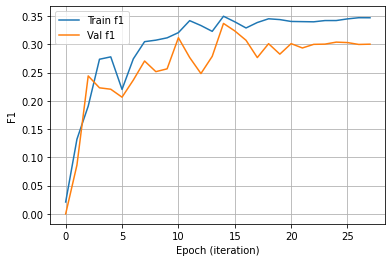

6070/6070 [==============================] - 17s 3ms/step - loss: 1.1074 - accuracy: 0.3799 - f1: 0.2979
Final loss 1 (cross-entropy and accuracy and F1): [1.1073529720306396, 0.37990114092826843, 0.2978582978248596]


In [28]:
# Experiment 1: hidden_layers = 1, total_nodes = 40, without normalization
shape = 20
X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh = dataset_preparation(shape=shape,normalization_type=None)
model1 = Sequential()
model1.add(LSTM(units= 40, input_shape= (X_train.shape[1], X_train.shape[2])))
model1.add(Dense(units= 3,activation='softmax'))
model1.summary()
model_name1 = 'First'
early_stop, monitor, lr_schedule = callbacks_function(model_name1)
model_history = model_comiple_run(model1,X_train,Y_train_oh,X_val,Y_val_oh,callbacks=[early_stop, monitor, lr_schedule])
model_plot(model_history)

model1.load_weights(model_name1)
loss1 = model1.evaluate(X_test, Y_test_oh, verbose=1,steps=X_test.shape[0])
print('Final loss 1 (cross-entropy and accuracy and F1):',loss1)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 40)                7680      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 123       
Total params: 7,803
Trainable params: 7,803
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
660/660 [==============================] - 4s 5ms/step - loss: 1.0616 - accuracy: 0.4294 - f1: 0.0747 - val_loss: 0.9882 - val_accuracy: 0.4778 - val_f1: 0.2413
Epoch 2/200
660/660 [==============================] - 3s 4ms/step - loss: 0.9587 - accuracy: 0.5255 - f1: 0.3518 - val_loss: 1.0511 - val_accuracy: 0.4745 - val_f1: 0.3649
Epoch 3/200
660/660 [==============================] - 3s 4ms/step - loss: 0.9129 - accuracy: 0.5541 - f1: 0.4459 - val_loss: 0.9776 - val_accuracy: 0.5222 - val_f1: 0

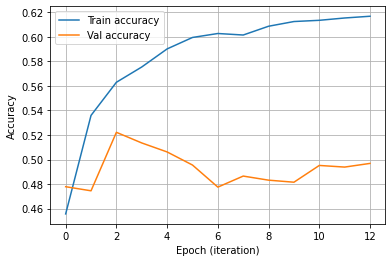

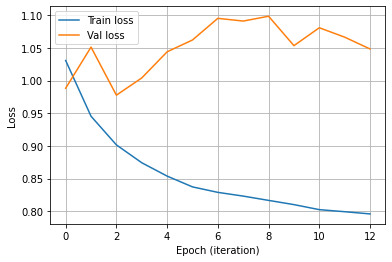

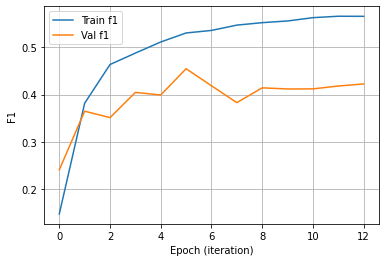

6070/6070 [==============================] - 17s 3ms/step - loss: 1.2246 - accuracy: 0.4155 - f1: 0.2778
Final loss (cross-entropy and accuracy and F1): [1.2246211767196655, 0.41548600792884827, 0.27775946259498596]


In [29]:
# Experiment 2: hidden_layers = 1, total_nodes = 40, with normalization = standardization
shape = 20
X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh = dataset_preparation(shape=shape)
model2 = Sequential()
model2.add(LSTM(units= 40, input_shape= (X_train.shape[1], X_train.shape[2])))
model2.add(Dense(units= 3,activation='softmax'))
model2.summary()
model_name2 = 'Second'
model_history = model_comiple_run(model2,X_train,Y_train_oh,X_val,Y_val_oh,callbacks=[callbacks_function(model_name2)])
model_plot(model_history)

model2.load_weights(model_name2)
loss2 = model2.evaluate(X_test, Y_test_oh, verbose=1,steps=X_test.shape[0])
print('Final loss (cross-entropy and accuracy and F1):',loss2)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 40)                7680      
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 123       
Total params: 7,803
Trainable params: 7,803
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
660/660 [==============================] - 5s 5ms/step - loss: 1.0830 - accuracy: 0.3964 - f1: 0.0954 - val_loss: 1.2211 - val_accuracy: 0.4502 - val_f1: 0.2067
Epoch 2/200
660/660 [==============================] - 3s 4ms/step - loss: 1.0331 - accuracy: 0.4640 - f1: 0.0980 - val_loss: 1.1441 - val_accuracy: 0.4572 - val_f1: 0.2231
Epoch 3/200
660/660 [==============================] - 3s 4ms/step - loss: 1.0039 - accuracy: 0.4730 - f1: 0.2711 - val_loss: 1.2051 - val_accuracy: 0.4908 - val_f1: 0

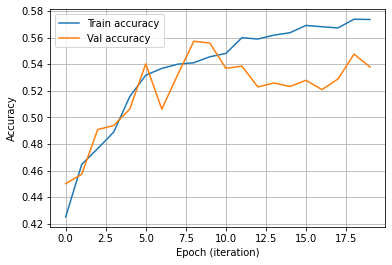

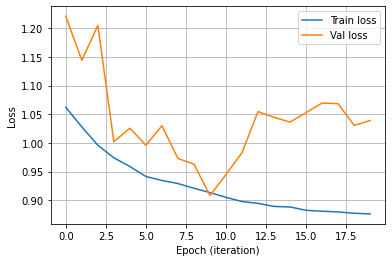

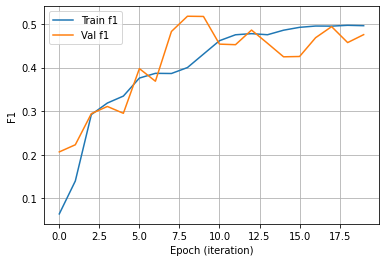

6070/6070 [==============================] - 17s 3ms/step - loss: 1.3021 - accuracy: 0.4582 - f1: 0.3949
Final loss (cross-entropy and accuracy and F1): [1.302054524421692, 0.4581548571586609, 0.3948928713798523]


In [30]:
# Experiment 3: hidden_layers = 1, total_nodes = 40 ,with normalization = min-max
shape = 20
X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh = dataset_preparation(shape=shape,normalization_type='min-max')
model3 = Sequential()
model3.add(LSTM(units= 40, input_shape= (X_train.shape[1], X_train.shape[2])))
model3.add(Dense(units= 3,activation='softmax'))
model3.summary()
model_name3 = 'Third'
model_history = model_comiple_run(model3,X_train,Y_train_oh,X_val,Y_val_oh,callbacks=[callbacks_function(model_name3)])
model_plot(model_history)

model3.load_weights(model_name3)
loss3 = model3.evaluate(X_test, Y_test_oh, verbose=1,steps=X_test.shape[0])
print('Final loss (cross-entropy and accuracy and F1):',loss3)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 40, 40)            7680      
_________________________________________________________________
lstm_34 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 123       
Total params: 20,763
Trainable params: 20,763
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
642/642 [==============================] - 7s 8ms/step - loss: 1.0548 - accuracy: 0.4396 - f1: 0.1069 - val_loss: 1.2278 - val_accuracy: 0.4734 - val_f1: 0.2617
Epoch 2/200
642/642 [==============================] - 4s 7ms/step - loss: 0.9570 - accuracy: 0.5067 - f1: 0.3417 - val_loss: 1.0772 - val_accuracy: 0.4940 - val_f1: 0.4531
Epoch 3/200
642/642 [============

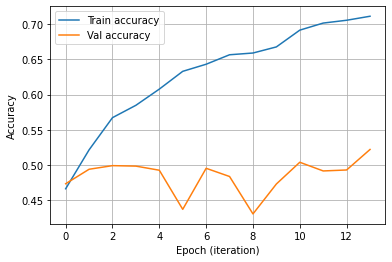

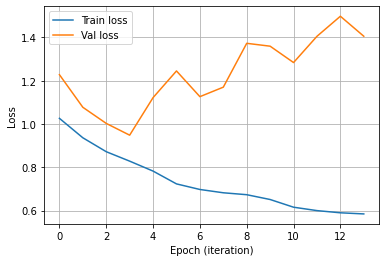

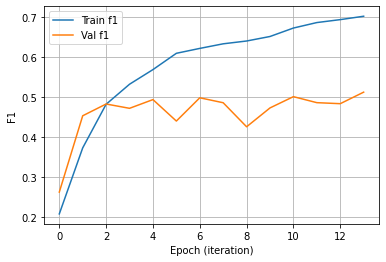

5909/5909 [==============================] - 22s 4ms/step - loss: 1.4007 - accuracy: 0.3483 - f1: 0.3219
Final loss (cross-entropy and accuracy and F1): [1.4006972312927246, 0.3482822775840759, 0.32188186049461365]


In [31]:
# Experiment 4: hidden_layers = 2, total_nodes = 80 ,with normalization = min-max
shape = 40
X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh = dataset_preparation(shape=shape,normalization_type='min-max')
model4 = Sequential()
model4.add(LSTM(units= 40, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model4.add(LSTM(units= 40, input_shape= (X_train.shape[1], X_train.shape[2])))
model4.add(Dense(units= 3,activation='softmax'))
model4.summary()
model_name4 = 'Fourth'
model_history = model_comiple_run(model4,X_train,Y_train_oh,X_val,Y_val_oh,callbacks=[callbacks_function(model_name4)])
model_plot(model_history)

model4.load_weights(model_name4)
loss4 = model4.evaluate(X_test, Y_test_oh, verbose=1,steps=X_test.shape[0])
print('Final loss (cross-entropy and accuracy and F1):',loss4)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 40, 80)            28160     
_________________________________________________________________
lstm_36 (LSTM)               (None, 40, 80)            51520     
_________________________________________________________________
lstm_37 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 243       
Total params: 131,443
Trainable params: 131,443
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
642/642 [==============================] - 10s 11ms/step - loss: 1.0324 - accuracy: 0.4600 - f1: 0.1963 - val_loss: 0.9658 - val_accuracy: 0.4882 - val_f1: 0.2348
Epoch 2/200
642/642 [==============================] - 6s 9ms/step - l

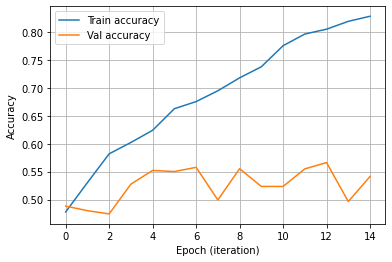

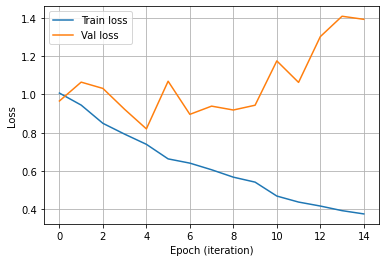

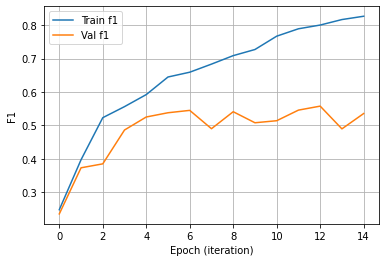

5909/5909 [==============================] - 41s 7ms/step - loss: 1.5429 - accuracy: 0.4090 - f1: 0.3639
Final loss 5 (cross-entropy and accuracy and F1): [1.5428789854049683, 0.4090370535850525, 0.3638516962528229]


In [32]:
# Experiment 5: hidden_layers = 3, total_nodes = 240 ,with normalization = min-max
shape = 40
X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh = dataset_preparation(shape=shape,normalization_type='min-max')
model5 = Sequential()
model5.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model5.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model5.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2])))
model5.add(Dense(units= 3,activation='softmax'))
model5.summary()
model_name5 = 'Fifth'
model_history = model_comiple_run(model5,X_train,Y_train_oh,X_val,Y_val_oh,callbacks=[callbacks_function(model_name5)])
model_plot(model_history)

model5.load_weights(model_name5)
loss5 = model5.evaluate(X_test, Y_test_oh, verbose=1,steps=X_test.shape[0])
print('Final loss 5 (cross-entropy and accuracy and F1):',loss5)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 40, 80)            28160     
_________________________________________________________________
dropout_21 (Dropout)         (None, 40, 80)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 40, 80)            51520     
_________________________________________________________________
dropout_22 (Dropout)         (None, 40, 80)            0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dropout_23 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)               

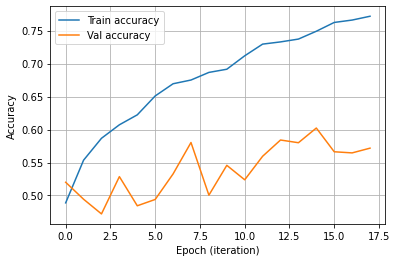

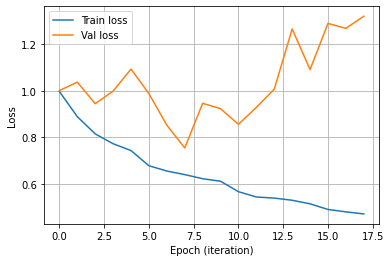

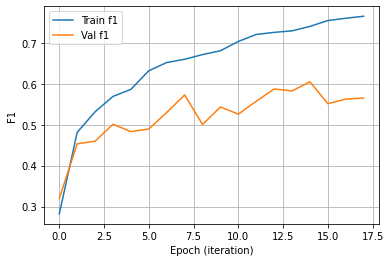

5909/5909 [==============================] - 41s 7ms/step - loss: 1.7212 - accuracy: 0.4260 - f1: 0.4202
Final loss 6 (cross-entropy and accuracy and F1): [1.7211812734603882, 0.42596039175987244, 0.4202064275741577]


In [33]:
# Experiment 6: hidden_layers = 3, total_nodes = 240 ,with normalization = min-max, adding dropout
shape = 40
X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh = dataset_preparation(shape=shape,normalization_type='min-max')
model6 = Sequential()
model6.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model6.add(Dropout(0.2))
model6.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model6.add(Dropout(0.2))
model6.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2])))
model6.add(Dropout(0.2))
model6.add(Dense(units= 3,activation='softmax'))
model6.summary()
model_name6 = 'Sixth'
model_history = model_comiple_run(model6,X_train,Y_train_oh,X_val,Y_val_oh,callbacks=[callbacks_function(model_name6)])
model_plot(model_history)

model6.load_weights(model_name6)
loss6 = model6.evaluate(X_test, Y_test_oh, verbose=1,steps=X_test.shape[0])
print('Final loss 6 (cross-entropy and accuracy and F1):',loss6)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 40, 80)            28160     
_________________________________________________________________
dropout_24 (Dropout)         (None, 40, 80)            0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 40, 80)            320       
_________________________________________________________________
lstm_42 (LSTM)               (None, 40, 80)            51520     
_________________________________________________________________
dropout_25 (Dropout)         (None, 40, 80)            0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 40, 80)            320       
_________________________________________________________________
lstm_43 (LSTM)               (None, 80)              

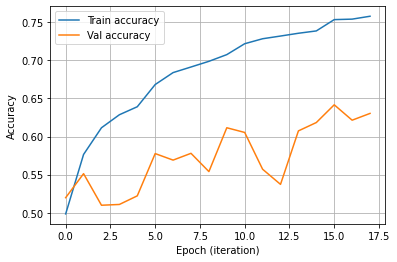

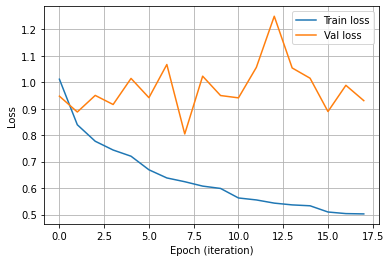

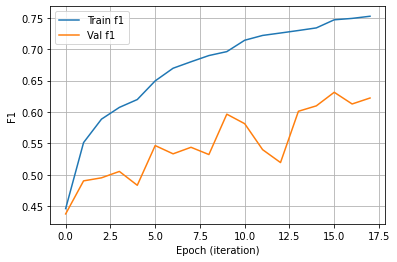

5909/5909 [==============================] - 43s 7ms/step - loss: 1.3187 - accuracy: 0.4043 - f1: 0.2909
Final loss 7 (cross-entropy and accuracy and F1): [1.3186888694763184, 0.4042985141277313, 0.2909121513366699]


In [34]:
# Experiment 7: hidden_layers = 3, total_nodes = 240 ,with normalization = min-max, adding dropout and Batch Normalization
shape = 40
X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh = dataset_preparation(shape=shape,normalization_type='min-max')
model7 = Sequential()
model7.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model7.add(Dropout(0.2))
model7.add(BatchNormalization())
model7.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model7.add(Dropout(0.2))
model7.add(BatchNormalization())
model7.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2])))
model7.add(Dropout(0.2))
model7.add(BatchNormalization())
model7.add(Dense(units= 3,activation='softmax'))
model7.summary()
model_name7 = 'Seventh'
model_history = model_comiple_run(model7,X_train,Y_train_oh,X_val,Y_val_oh,callbacks=[callbacks_function(model_name7)])
model_plot(model_history)

model7.load_weights(model_name7)
loss7 = model7.evaluate(X_test, Y_test_oh, verbose=1,steps=X_test.shape[0])
print('Final loss 7 (cross-entropy and accuracy and F1):',loss7)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 40, 80)            28160     
_________________________________________________________________
dropout_27 (Dropout)         (None, 40, 80)            0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 40, 80)            320       
_________________________________________________________________
lstm_45 (LSTM)               (None, 40, 80)            51520     
_________________________________________________________________
dropout_28 (Dropout)         (None, 40, 80)            0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 40, 80)            320       
_________________________________________________________________
lstm_46 (LSTM)               (None, 80)              

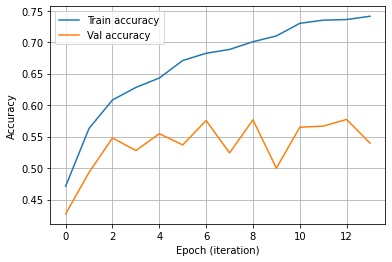

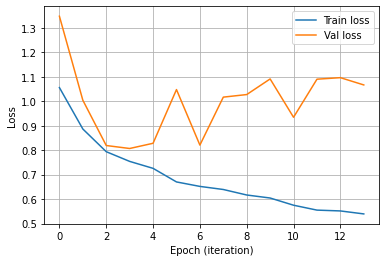

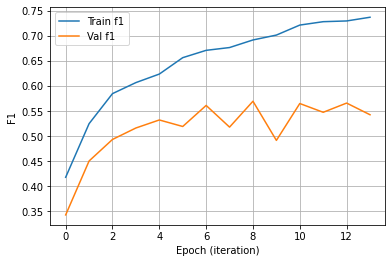

5909/5909 [==============================] - 43s 7ms/step - loss: 1.5207 - accuracy: 0.3466 - f1: 0.3331
Final loss 8 (cross-entropy and accuracy and F1): [1.520749568939209, 0.34658995270729065, 0.33305126428604126]


In [35]:
# Experiment 8: hidden_layers = 3, total_nodes = 240 ,with normalization = min-max, 
# adding dropout and Batch Normalization and shuffling the training dataset
shape = 40
X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh = dataset_preparation(shape=shape,normalization_type='min-max')

indexes = np.arange(X_train.shape[0])
np.random.shuffle(indexes)
X_train = X_train[indexes,]
Y_train_oh = Y_train_oh[indexes,]

model8 = Sequential()
model8.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model8.add(Dropout(0.2))
model8.add(BatchNormalization())
model8.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model8.add(Dropout(0.2))
model8.add(BatchNormalization())
model8.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2])))
model8.add(Dropout(0.2))
model8.add(BatchNormalization())
model8.add(Dense(units= 3,activation='softmax'))
model8.summary()
model_name8 = 'Eighth'
model_history = model_comiple_run(model8,X_train,Y_train_oh,X_val,Y_val_oh,callbacks=[callbacks_function(model_name8)])
model_plot(model_history)

model8.load_weights(model_name8)
loss8 = model8.evaluate(X_test, Y_test_oh, verbose=1,steps=X_test.shape[0])
print('Final loss 8 (cross-entropy and accuracy and F1):',loss8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 40, 80)            29440     
_________________________________________________________________
dropout_30 (Dropout)         (None, 40, 80)            0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 40, 80)            320       
_________________________________________________________________
lstm_48 (LSTM)               (None, 40, 80)            51520     
_________________________________________________________________
dropout_31 (Dropout)         (None, 40, 80)            0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 40, 80)            320       
_________________________________________________________________
lstm_49 (LSTM)               (None, 80)              

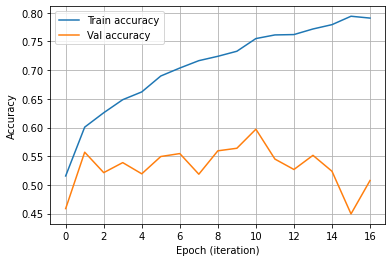

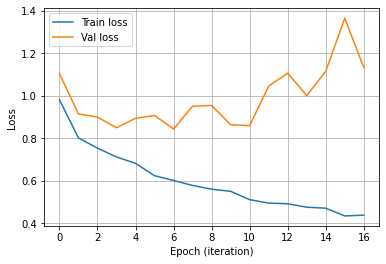

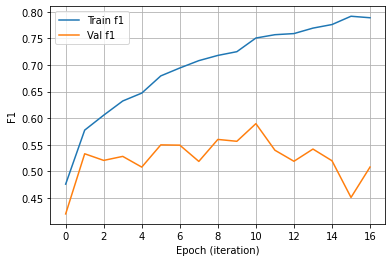

5909/5909 [==============================] - 43s 7ms/step - loss: 1.5711 - accuracy: 0.3342 - f1: 0.3209
Final loss 9 (cross-entropy and accuracy and F1): [1.5710532665252686, 0.33423590660095215, 0.3208664655685425]


In [36]:
# Experiment 9: hidden_layers = 3, total_nodes = 240 ,with normalization = min-max, 
# adding dropout and Batch Normalization and shuffling the training dataset and adding delta
shape = 40
X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh = dataset_preparation(shape=shape,normalization_type='min-max',delta= True)

indexes = np.arange(X_train.shape[0])
np.random.shuffle(indexes)
X_train = X_train[indexes,]
Y_train_oh = Y_train_oh[indexes,]

model9 = Sequential()
model9.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model9.add(Dropout(0.2))
model9.add(BatchNormalization())
model9.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model9.add(Dropout(0.2))
model9.add(BatchNormalization())
model9.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2])))
model9.add(Dropout(0.2))
model9.add(BatchNormalization())
model9.add(Dense(units= 3,activation='softmax'))
model9.summary()
model_name9 = 'Eighth'
model_history = model_comiple_run(model9,X_train,Y_train_oh,X_val,Y_val_oh,callbacks=[callbacks_function(model_name9)])
model_plot(model_history)

model9.load_weights(model_name9)
loss9 = model9.evaluate(X_test, Y_test_oh, verbose=1,steps=X_test.shape[0])
print('Final loss 9 (cross-entropy and accuracy and F1):',loss9)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 40, 80)            29440     
_________________________________________________________________
dropout_33 (Dropout)         (None, 40, 80)            0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 40, 80)            320       
_________________________________________________________________
lstm_51 (LSTM)               (None, 40, 80)            51520     
_________________________________________________________________
dropout_34 (Dropout)         (None, 40, 80)            0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 40, 80)            320       
_________________________________________________________________
lstm_52 (LSTM)               (None, 80)              

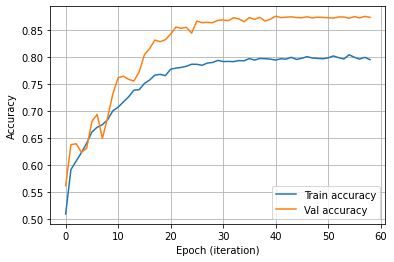

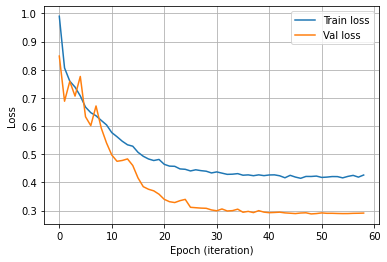

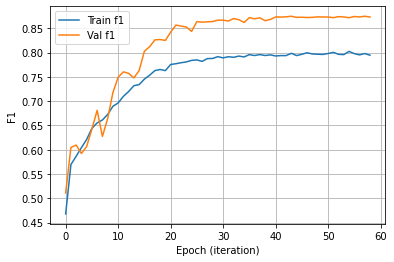

5909/5909 [==============================] - 43s 7ms/step - loss: 0.2998 - accuracy: 0.8587 - f1: 0.8428
Final loss 9 (cross-entropy and accuracy and F1): [0.29980722069740295, 0.8586901426315308, 0.8427821397781372]


In [37]:
# Experiment 10: hidden_layers = 3, total_nodes = 240 ,with normalization = min-max, 
# adding dropout and Batch Normalization and shuffling before splitting the training dataset and adding delta

shape = 40
X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh = \
dataset_preparation(shape=shape,normalization_type='min-max',delta= True,shuffle=True)

model10 = Sequential()
model10.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model10.add(Dropout(0.2))
model10.add(BatchNormalization())
model10.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model10.add(Dropout(0.2))
model10.add(BatchNormalization())
model10.add(LSTM(units= 80, input_shape= (X_train.shape[1], X_train.shape[2])))
model10.add(Dropout(0.2))
model10.add(BatchNormalization())
model10.add(Dense(units= 3,activation='softmax'))
model10.summary()
model_name10 = 'Tenth'
model_history = model_comiple_run(model10,X_train,Y_train_oh,X_val,Y_val_oh,callbacks=[callbacks_function(model_name10)])
model_plot(model_history)

model10.load_weights(model_name10)
loss10 = model10.evaluate(X_test, Y_test_oh, verbose=1,steps=X_test.shape[0])
print('Final loss 9 (cross-entropy and accuracy and F1):',loss10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 80, 160)           110080    
_________________________________________________________________
dropout_36 (Dropout)         (None, 80, 160)           0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 80, 160)           640       
_________________________________________________________________
lstm_54 (LSTM)               (None, 80, 160)           205440    
_________________________________________________________________
dropout_37 (Dropout)         (None, 80, 160)           0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 80, 160)           640       
_________________________________________________________________
lstm_55 (LSTM)               (None, 160)             

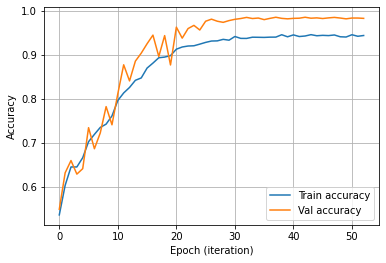

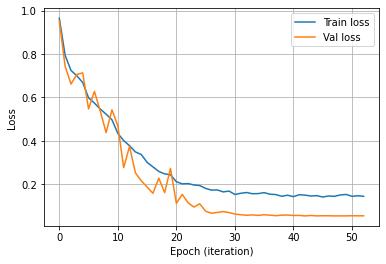

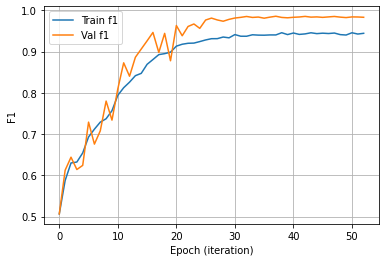

5589/5589 [==============================] - 61s 11ms/step - loss: 0.0503 - accuracy: 0.9862 - f1: 0.9857
Final loss 9 (cross-entropy and accuracy and F1): [0.05025198310613632, 0.9862229228019714, 0.9856860637664795]


In [38]:
# Experiment 11: hidden_layers = 3, total_nodes = 240 ,with normalization = min-max, 
# adding dropout and Batch Normalization and shuffling before splitting the training dataset and adding delta

shape = 80
X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh = \
dataset_preparation(shape=shape,normalization_type='min-max',delta= True,shuffle=True)

model11 = Sequential()
model11.add(LSTM(units= 160, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model11.add(Dropout(0.2))
model11.add(BatchNormalization())
model11.add(LSTM(units= 160, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model11.add(Dropout(0.2))
model11.add(BatchNormalization())
model11.add(LSTM(units= 160, input_shape= (X_train.shape[1], X_train.shape[2])))
model11.add(Dropout(0.2))
model11.add(BatchNormalization())
model11.add(Dense(units= 3,activation='softmax'))
model11.summary()
model_name11 = 'Eleventh'
model_history = model_comiple_run(model11,X_train,Y_train_oh,X_val,Y_val_oh,callbacks=[callbacks_function(model_name11)])
model_plot(model_history)

model11.load_weights(model_name11)
loss11 = model11.evaluate(X_test, Y_test_oh, verbose=1,steps=X_test.shape[0])
print('Final loss 9 (cross-entropy and accuracy and F1):',loss11)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 80, 160)           110080    
_________________________________________________________________
dropout_39 (Dropout)         (None, 80, 160)           0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 80, 160)           640       
_________________________________________________________________
lstm_57 (LSTM)               (None, 80, 160)           205440    
_________________________________________________________________
dropout_40 (Dropout)         (None, 80, 160)           0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 80, 160)           640       
_________________________________________________________________
lstm_58 (LSTM)               (None, 160)             

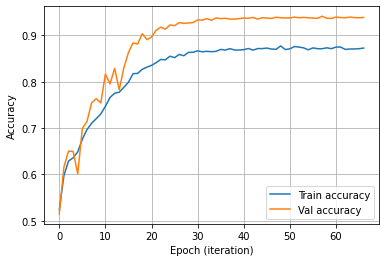

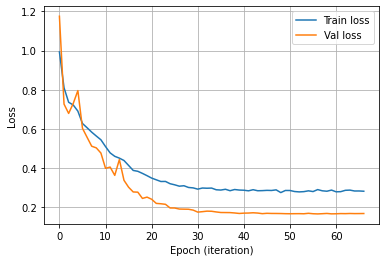

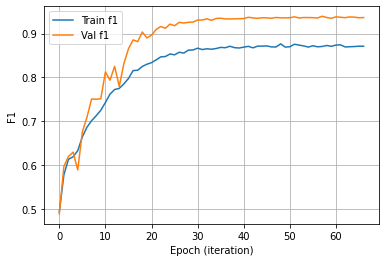

5589/5589 [==============================] - 62s 11ms/step - loss: 0.1768 - accuracy: 0.9281 - f1: 0.9218
Final loss 12 (cross-entropy and accuracy and F1): [0.17676539719104767, 0.928072988986969, 0.9218106269836426]


In [39]:
# Experiment 12: hidden_layers = 3, total_nodes = 240 ,with normalization = min-max, 
# adding dropout and Batch Normalization and shuffling before splitting the training dataset and adding delta
# With generalize dataset

shape = 80
X_train, X_val, X_test, Y_train_oh, Y_val_oh, Y_test_oh = \
dataset_preparation(shape=shape,normalization_type='min-max',delta= True,shuffle=True,get_generalized = True)

model12 = Sequential()
model12.add(LSTM(units= 160, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model12.add(Dropout(0.2))
model12.add(BatchNormalization())
model12.add(LSTM(units= 160, input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
model12.add(Dropout(0.2))
model12.add(BatchNormalization())
model12.add(LSTM(units= 160, input_shape= (X_train.shape[1], X_train.shape[2])))
model12.add(Dropout(0.2))
model12.add(BatchNormalization())
model12.add(Dense(units= 3,activation='softmax'))
model12.summary()
model_name12 = 'twelve'
model_history = model_comiple_run(model12,X_train,Y_train_oh,X_val,Y_val_oh,callbacks=[callbacks_function(model_name12)])
model_plot(model_history)

model12.load_weights(model_name12)
loss12 = model12.evaluate(X_test, Y_test_oh, verbose=1,steps=X_test.shape[0])
print('Final loss 12 (cross-entropy and accuracy and F1):',loss12)